In [1]:
import sys
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development import (
    Sequential,
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Linear,
    ReLU,
    ReLU6,
    MaxPool2d,
    Flatten, 

    EarlyStopper,
    dequantize_per_tensor_sy,
    Estimator,
    
    QuantizationGranularity,
    QuantizationScaleType,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
torch.__version__

'2.7.1+cu126'

In [3]:
import sys
import os
import copy, itertools
import random

from tqdm.auto import tqdm

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lenet5_file = f"lenet5_state_dict.pth"
log_compression_details_file = "lenet5_compression_log.csv"

hp_deployment_base_dir = "./HP HP Pavilion Laptop 15-cs3xxx/"
hp_src_dir = os.path.join(hp_deployment_base_dir, "src")
hp_include_dir = os.path.join(hp_deployment_base_dir, "include")

arduino_deployment_base_dir = "./Arduino Nano 33 BLE/"
arduino_src_dir = os.path.join(arduino_deployment_base_dir, "src")
arduino_include_dir = os.path.join(arduino_deployment_base_dir, "include")

LUCKY_NUMBER = 25
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

DEVICE

'cuda'

In [4]:
input_shape = (1, 28, 28)

data_transform = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST("../../../Datasets/", train=True, download=True, transform=data_transform)
mnist_test_dataset = datasets.MNIST("../../../Datasets/", train=False, download=True, transform=data_transform)

mnist_train_loader = data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)
mnist_test_loader = data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [5]:
lenet5_model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, pad=tuple([2]*4), bias=False),
    BatchNorm2d(num_features=6),
    ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
    BatchNorm2d(num_features=16),
    ReLU(),
    # ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),
    # AvgPool2d(kernel_size=2, stride=2, padding=0),

    Flatten(),
    
    Linear(in_features=16*5*5, out_features=84, bias=False),
    ReLU(),
    Linear(in_features=84, out_features=10, bias=True)
).to(DEVICE)

accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()*100

In [6]:
# lenet5_model = Sequential(
#     Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     # BatchNorm2d(num_features=3),
#     ReLU(),
#     Conv2d(in_channels=6, out_channels=3, kernel_size=1, stride=1, pad=[0]*4, bias=False),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=84, bias=False),
#     ReLU(),
#     Linear(in_features=84, out_features=10, bias=True)
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [7]:
# lenet5_model = Sequential(
    
#     Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     ReLU(),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     # BatchNorm2d(num_features=3),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=10, bias=True),
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [8]:
try:
    # raise RuntimeError
    lenet5_model.cpu()
    lenet5_model.load_state_dict(torch.load(lenet5_file, weights_only=True), strict=False)
    lenet5_model.to(DEVICE)

except (RuntimeError, FileNotFoundError) as e:
    early_stopper = EarlyStopper(
        metric_name="validation_loss",
        min_valid_diff=1e-7,
        mode="min",
        patience=4,
        restore_best_state_dict=True,
    )

    criterion_fun = nn.CrossEntropyLoss()
    optimizion_fun = optim.Adam(lenet5_model.parameters(), lr=1.e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

    lenet5_model.fit(
        mnist_train_loader, 25, 
        criterion_fun, optimizion_fun, lr_scheduler,
        validation_dataloader=mnist_test_loader, 
        metrics={"acc" : accuracy_fun},
        callbacks=[early_stopper],
        device=DEVICE
    )
    lenet5_model.cpu()
    torch.save(lenet5_model.state_dict(), lenet5_file)
    lenet5_model.to(DEVICE)
    

In [9]:
# early_stopper = EarlyStopper(
#     metric_name="validation_loss",
#     min_valid_diff=1e-4,
#     mode="min",
#     patience=2,
#     restore_best_state_dict=True,
# )

# criterion_fun = nn.CrossEntropyLoss()
# optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
# lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



# sensitivity = lenet5_model.get_layers_prune_channel_sensity(
#     input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun}, device=DEVICE,
#     train=True,
#     train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
#     lr_scheduler=lr_scheduler, 
# )

In [10]:
param = list()

In [11]:

    criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

param += lenet5_model.get_nas_prune_channel(input_shape, mnist_test_loader, accuracy_fun, DEVICE, num_data=400, 
                                            train=True,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, )
estimator = Estimator(param, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=500)


IndentationError: unexpected indent (567008283.py, line 1)

In [ ]:
len(torch.load("get_nas_param_with_training"))

500

In [ ]:
torch.save(param, "get_nas_param_with_training")

In [ ]:
estimator_history

{'validation_loss': [tensor(355.1248, device='cuda:0'),
  tensor(340.5578, device='cuda:0'),
  tensor(290.3071, device='cuda:0'),
  tensor(165.1139, device='cuda:0'),
  tensor(28.1457, device='cuda:0'),
  tensor(16.0072, device='cuda:0'),
  tensor(26.4479, device='cuda:0'),
  tensor(22.1945, device='cuda:0'),
  tensor(19.8258, device='cuda:0'),
  tensor(24.0395, device='cuda:0'),
  tensor(19.7391, device='cuda:0'),
  tensor(18.6076, device='cuda:0'),
  tensor(20.1053, device='cuda:0'),
  tensor(19.2924, device='cuda:0'),
  tensor(22.1729, device='cuda:0'),
  tensor(16.7815, device='cuda:0'),
  tensor(15.4645, device='cuda:0'),
  tensor(16.6608, device='cuda:0'),
  tensor(17.6951, device='cuda:0'),
  tensor(18.9514, device='cuda:0'),
  tensor(16.7353, device='cuda:0'),
  tensor(14.6157, device='cuda:0'),
  tensor(12.9355, device='cuda:0'),
  tensor(14.9380, device='cuda:0'),
  tensor(15.6660, device='cuda:0'),
  tensor(18.0503, device='cuda:0'),
  tensor(14.1748, device='cuda:0'),
  ten

In [ ]:
len(param)

500

In [ ]:

best_metric = float("-inf")
best_comb = None
best_size = float("inf")
original_size = lenet5_model.get_size_in_bytes()


def get_all_combinations(flat_dict: dict[str, list]):
    keys = list(flat_dict.keys())
    values = list(flat_dict.values())
    product = itertools.product(*values)

    for comb in product:
        yield {key: value for key, value in zip(keys, comb)}

        
result = []

original_metric = estimator.predict(torch.Tensor([0, 0, 0]))
print(original_metric)

for prune_comb in get_all_combinations(lenet5_model.get_prune_channel_possible_hypermeters()):
    metric = estimator.predict(torch.Tensor(list(prune_comb.values())))
    
    compression_config = {
        "prune_channel" :{
            "sparsity" : prune_comb,
            "metric" : "l2"
        },
    }

    if metric > 0.965 * original_metric:
        
        size = lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size
        if size < best_size:
            best_comb = prune_comb
            best_size = size
            print(metric, size, best_comb)
    # if lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size < 5:

    #     result.append((prune_comb, metric))

    #     if metric > best_metric:
    #         best_metric = metric
    #         best_comb = prune_comb

    #         print(best_comb, best_metric)


95.9630126953125
95.9630126953125 1.0 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 0, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.97836303710938 0.9889368591473287 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 1, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.99087524414062 0.9778737182946573 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 2, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.0018081665039 0.966810577441986 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 3, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.01089477539062 0.9557474365893146 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 4

In [ ]:
best_comb

{'conv2d_0': 0,
 'conv2d_1': 15,
 'linear_0': 0,
 'batchnorm2d_0': 0,
 'relu6_0': 0,
 'maxpool2d_0': 0,
 'batchnorm2d_1': 0,
 'relu_0': 0,
 'maxpool2d_1': 0,
 'flatten_0': 0,
 'relu_1': 0,
 'linear_1': 0}

In [ ]:
best_pruned_model = lenet5_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    }
}, input_shape).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(best_pruned_model.parameters(), lr=1.e-3, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

best_pruned_model.fit(
    mnist_train_loader, 20, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:12<03:48, 12.03s/it]

epoch    0 | train loss 0.0050 | validation loss 0.0032 | train acc 95.0417 | validation acc 96.6500


 10%|█         | 2/20 [00:25<03:47, 12.62s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0024 | train acc 97.2533 | validation acc 97.5100


 15%|█▌        | 3/20 [00:37<03:35, 12.66s/it]

epoch    2 | train loss 0.0025 | validation loss 0.0020 | train acc 97.5417 | validation acc 97.8700


 20%|██        | 4/20 [00:50<03:21, 12.62s/it]

epoch    3 | train loss 0.0022 | validation loss 0.0019 | train acc 97.7300 | validation acc 98.0700


 25%|██▌       | 5/20 [01:03<03:11, 12.76s/it]

epoch    4 | train loss 0.0020 | validation loss 0.0017 | train acc 98.0117 | validation acc 98.2100


 30%|███       | 6/20 [01:16<02:59, 12.85s/it]

epoch    5 | train loss 0.0020 | validation loss 0.0018 | train acc 98.0317 | validation acc 98.4000


 35%|███▌      | 7/20 [01:29<02:48, 12.98s/it]

epoch    6 | train loss 0.0019 | validation loss 0.0017 | train acc 98.0967 | validation acc 98.3100


 40%|████      | 8/20 [01:44<02:44, 13.69s/it]

epoch    7 | train loss 0.0018 | validation loss 0.0017 | train acc 98.2083 | validation acc 98.1800


 45%|████▌     | 9/20 [02:02<02:45, 15.07s/it]

epoch    8 | train loss 0.0017 | validation loss 0.0017 | train acc 98.2467 | validation acc 98.3100


 50%|█████     | 10/20 [02:15<02:23, 14.31s/it]

epoch    9 | train loss 0.0017 | validation loss 0.0016 | train acc 98.2750 | validation acc 98.3700


 55%|█████▌    | 11/20 [02:28<02:04, 13.82s/it]

epoch   10 | train loss 0.0016 | validation loss 0.0015 | train acc 98.3217 | validation acc 98.3200


 60%|██████    | 12/20 [02:40<01:46, 13.32s/it]

epoch   11 | train loss 0.0015 | validation loss 0.0015 | train acc 98.4217 | validation acc 98.4800


 65%|██████▌   | 13/20 [02:52<01:30, 12.96s/it]

epoch   12 | train loss 0.0016 | validation loss 0.0014 | train acc 98.3817 | validation acc 98.6000


 70%|███████   | 14/20 [03:04<01:16, 12.67s/it]

epoch   13 | train loss 0.0016 | validation loss 0.0015 | train acc 98.4567 | validation acc 98.4500


 75%|███████▌  | 15/20 [03:16<01:02, 12.54s/it]

epoch   14 | train loss 0.0015 | validation loss 0.0013 | train acc 98.5000 | validation acc 98.6100


 80%|████████  | 16/20 [03:29<00:50, 12.61s/it]

epoch   15 | train loss 0.0015 | validation loss 0.0016 | train acc 98.4400 | validation acc 98.3900


 85%|████████▌ | 17/20 [03:42<00:37, 12.58s/it]

epoch   16 | train loss 0.0015 | validation loss 0.0013 | train acc 98.4917 | validation acc 98.5100


 90%|█████████ | 18/20 [03:54<00:25, 12.56s/it]

epoch   17 | train loss 0.0014 | validation loss 0.0015 | train acc 98.6433 | validation acc 98.4200


 95%|█████████▌| 19/20 [04:09<00:13, 13.12s/it]

epoch   18 | train loss 0.0013 | validation loss 0.0013 | train acc 98.6550 | validation acc 98.5700


100%|██████████| 20/20 [04:22<00:00, 13.14s/it]

epoch   19 | train loss 0.0013 | validation loss 0.0015 | train acc 98.6933 | validation acc 98.5900


{'validation_loss': [tensor(0.0032, device='cuda:0'),
  tensor(0.0024, device='cuda:0'),
  tensor(0.0020, device='cuda:0'),
  tensor(0.0019, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0018, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0014, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0')],
 'validation_acc': [96.65,
  97.51,
  97.87,
  98.07,
  98.21,
  98.4,
  98.31,
  98.18,
  98.31,
  98.37,
  98.32,
  98.48,
  98.6,
  98.45,
  98.61,
  98.39,
  98.51,
  98.42,
  98.57,
  98.59],
 'train_loss': [0.0050320519860213,
  0.0028521709499317997,
  0.002507683808061604

In [ ]:
next(iter(mnist_test_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [12]:
best_pruned_model = torch.load("best_pruned_model{'conv2d_0': 5, 'conv2d_1': 15, 'linear_0': 83}", weights_only=False)

In [13]:
best_pruned_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)

100%|██████████| 313/313 [00:01<00:00, 226.66it/s]


{'acc': 98.59}

In [17]:
quantized_model = best_pruned_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    },
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "granularity": QuantizationGranularity.PER_TENSOR,
        "bitwidth": 4
    }
}, input_shape, next(iter(mnist_test_loader))[0].to(DEVICE)).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(quantized_model.parameters(), lr=1.e-4, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

quantized_model.fit(
    mnist_train_loader, 3, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


 33%|███▎      | 1/3 [00:26<00:52, 26.02s/it]

epoch    0 | train loss 0.0031 | validation loss 0.0030 | train acc 96.5533 | validation acc 96.7300


 67%|██████▋   | 2/3 [00:52<00:26, 26.31s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0025 | train acc 96.7217 | validation acc 97.3000


100%|██████████| 3/3 [01:20<00:00, 26.74s/it]

epoch    2 | train loss 0.0028 | validation loss 0.0027 | train acc 96.9067 | validation acc 97.2900


{'validation_loss': [tensor(0.0030, device='cuda:0'),
  tensor(0.0025, device='cuda:0'),
  tensor(0.0027, device='cuda:0')],
 'validation_acc': [96.73, 97.3, 97.29],
 'train_loss': [0.003146008840368207,
  0.0029256463757017627,
  0.002808011225054118],
 'train_acc': [96.55333333333333, 96.72166666666666, 96.90666666666667]}

In [ ]:
quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)


100%|██████████| 313/313 [00:01<00:00, 158.98it/s]


{'acc': 98.49}

In [ ]:
nn.Conv1d

In [ ]:
quantized_model.get_size_in_bytes()

7706

In [ ]:
torch.save(best_pruned_model, f"best_pruned_model{prune_comb}")

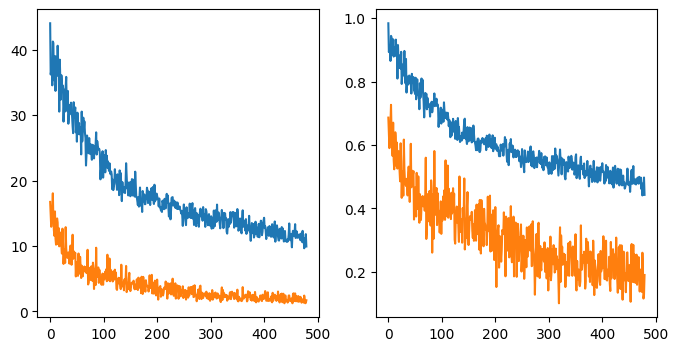

In [ ]:
start_num = 20

fig, axes = plt.subplots(1,2, figsize = (8, 4))
axes[0].plot(range(len(estimator_history["train_loss"])-start_num), estimator_history["train_loss"][start_num:])
axes[0].plot(range(len(estimator_history["validation_loss"])-start_num), list(map(lambda x: x.detach().cpu().numpy(), estimator_history["validation_loss"]))[start_num:])

axes[1].plot(range(len(estimator_history["train_abs"])-start_num), estimator_history["train_abs"][start_num:])
axes[1].plot(range(len(estimator_history["validation_abs"])-start_num), estimator_history["validation_abs"][start_num:])

In [ ]:
estimator.predict(torch.Tensor([0,0,7]))

94.1739501953125

In [ ]:
lenet5_model["linear_0"].get_size_in_bits()//8

134400

In [ ]:
best_pruned_model['linear_0'].get_size_in_bits()//8


23800

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



sensitivity = lenet5_model.get_layers_prune_channel_sensity_(
    input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun, "acc1":accuracy_fun}, device=DEVICE,
    train=False,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

AttributeError: 'Sequential' object has no attribute 'get_layers_prune_channel_sensity_'

6 [(0.0, 99.22), (0.16666666666666666, 97.47), (0.3333333333333333, 71.31), (0.5, 40.65), (0.6666666666666666, 28.36), (0.8333333333333334, 13.94)]
16 [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96), (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97), (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)]
84 [(0.0, 99.05), (0.011904761904761904, 99.08), (0.023809523809523808, 99.04), (0.03571428571428571, 99.2), (0.047619047619047616, 98.98), (0.05952380952380952, 99.19), (0.07142857142857142, 99.16), (0.08333333333333333, 99.09), (0.09523809523809523, 99.09), (0.10714285714285714, 99.11), (0.11904761904761904, 99.18), (0.13095238095238096, 99.07), (0.14285714285714285, 99.1), (0.15476190476190477, 99.08), (0.16666666666666666, 99.03), (0.17857142857142858, 99.28), (0.19047619047619047, 99.25), (0.20238095238095238, 99.17), (0.21428571428571427, 99.14), (0.2261904761904762, 99.07), (0.23

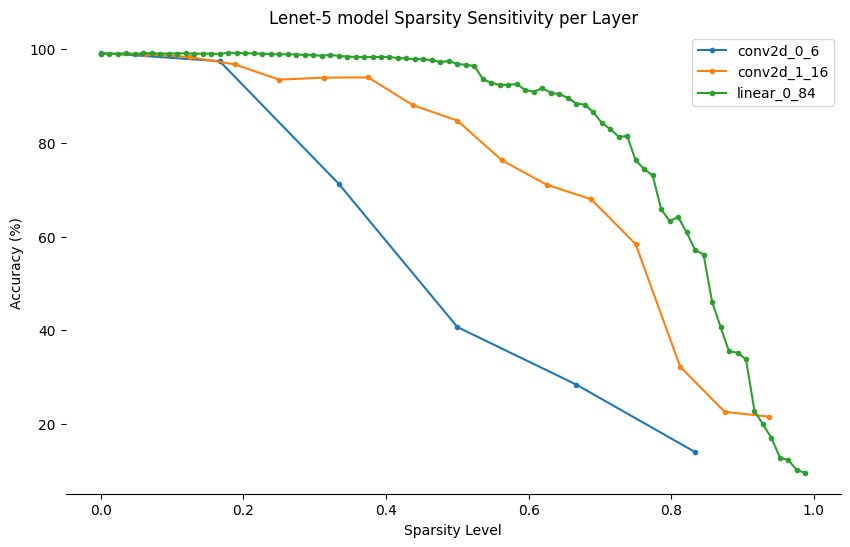

In [ ]:
plt.figure(figsize=(10, 6))
for layer, values in sensitivity['acc'].items():
    print(len(values), values)
    sparsity, acc = zip(*values)
    plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
plt.legend()
plt.grid(False)

list(plt.gca().spines.values())[0].set_visible(False)
list(plt.gca().spines.values())[1].set_visible(False)
list(plt.gca().spines.values())[3].set_visible(False)

plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
plt.show()


4

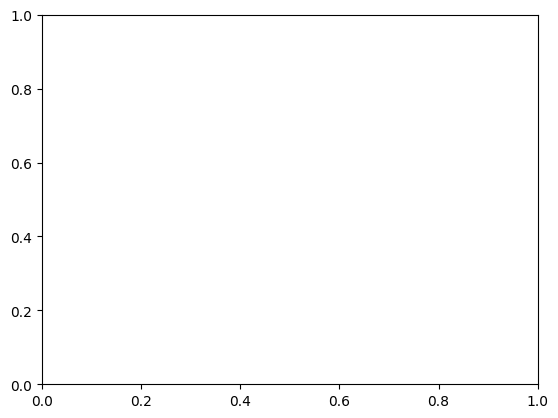

In [ ]:
len(plt.gca().spines.values())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

# Your dataset
acc_data = {
    'conv2d_0': [(0.0, 99.22), (0.1667, 97.47), (0.3333, 71.31), (0.5, 40.65), (0.6667, 28.36), (0.8333, 13.94)],
    'conv2d_1': [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96),
                 (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97),
                 (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)],
    'linear_0': [
        (0.0, 99.05), (0.1667, 99.03), (0.3333, 98.61), (0.5, 96.88), (0.6667, 88.4),
        (0.75, 76.29), (0.8333, 57.14), (0.9167, 22.73), (1.0, 9.52)
    ]
}

# Build dataset as combinations of sparsities
X, y = [], []
for s0, _ in acc_data['conv2d_0']:
    for s1, _ in acc_data['conv2d_1']:
        for s2, acc in acc_data['linear_0']:
            # Features = sparsity levels
            X.append([s0, s1, s2])
            # Approx target = min accuracy among layers (proxy)
            y.append(acc)  

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Example prediction
test_sparsity = torch.tensor([[0.5, 0.25, 0.33]])  # (conv2d_0, conv2d_1, linear_0)
pred_acc = model(test_sparsity).item()
print(f"Predicted Accuracy: {pred_acc:.2f}%")


Epoch 100, Loss: 5958.7373
Epoch 200, Loss: 4314.2148
Epoch 300, Loss: 2123.2832
Epoch 400, Loss: 1662.4471
Epoch 500, Loss: 1510.1141
Predicted Accuracy: 58.12%


## Original Model


In [ ]:
lenet5_mcu_model = copy.deepcopy(lenet5_model)

evaluate_result = lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 239.41it/s]


The original model accuracy is 9915.00% with size 148240 bytes.
tensor([[-29.0016, -22.3953, -21.4715,  30.5191, -33.2081,   0.8119, -33.4459,
         -16.0511,  -6.0006,  -9.6175]], device='cuda:0')


(99.15, 148240)

In [ ]:
fused_lenet5_mcu_model = lenet5_mcu_model.fuse().to(DEVICE)

evaluate_result = fused_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = fused_lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# fused_lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
fused_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# print(fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone()))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 231.04it/s]


The original model accuracy is 9911.00% with size 148088 bytes.
tensor([[-20.5041, -15.5337,  -1.6605,  -2.1882, -20.7473, -12.2588, -37.9503,
          14.2805, -11.3950,  -7.5340]], device='cuda:0')


(99.11, 148088)

In [ ]:
lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), 

(tensor([[-10.9922, -21.7113, -15.5854,   4.6235, -25.0249,   9.8817,  -9.2897,
          -15.5343,   0.8853,  -8.7347]], device='cuda:0'),)

In [ ]:
fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), \
fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# compression_dict = lenet5_mcu_model.get_all_compression_hyperparameter()
# print(len(compression_dict))
# print((compression_dict)[0])
# lenet5_mcu_model.decode_compression_dict_hyperparameter(compression_dict[0])

In [ ]:
# sp = .9

s = QuantizationScheme.DYNAMIC
g = QuantizationGranularity.PER_TENSOR
b = 4
compression_config = {
    # "prune_channel" :{
    #     "sparsity" : sp,
    #     "metric" : "l2"
    # },
    "quantize" : {
        "scheme" : s,
        "granularity": g,
        "bitwidth" : b
    }
}

# compressed_lenet5_mcu_model = lenet5_mcu_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
compressed_lenet5_mcu_model = lenet5_mcu_model.fuse().init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
before_acc = compressed_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)["acc"]
# compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir)
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir)

size = compressed_lenet5_mcu_model.get_size_in_bits()//8
print(f"Before training, sparsity = {sp}, scheme = {s.name}, granularity = {g.name}, bitwidth = {b} acc = {before_acc:.4f} size = {size/original_size*100:9.4f} {100 - size/original_size*100:9.4f}")

print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir))
print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir))


100%|██████████| 313/313 [00:01<00:00, 171.57it/s]


NameError: name 'sp' is not defined